# Analysis of HPL

This notebook performs data analysis of the csv files created by running the HPL benchmark

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

# Standardise Fonts
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=10)
plt.rc("axes", labelsize=8)

In [2]:
# Store the results in a dictionary of lists
results = {
    "Cloud_HPL":[],
    "SCARF_HPL":[],
    "JASMIN_HPL":[]
}

# Parse data from csvs from each of the different results
for dataName in results:
    with open("../" + dataName + "/out.csv", "r") as fHandle:
        reader = csv.reader(fHandle)  # create an iterator over each row
        headers = next(reader) # the headers are the first line
        for row in reader:
            thisRow = dict((header, row[index]) for index, header in enumerate(headers))
            results[dataName].append(thisRow)
            

# Print a taste of the data, for a quick check that it worked
for dataName in results:
    print(dataName)
    print("1st datapoints")
    print(results[dataName][0])
    print("Headers")
    print(results[dataName][0].keys())
    print()
        

SCARF_HPL
1st datapoints
{'Time': '447.67', 'Delta Memory (MB)': '-', 'T/V': 'WR11R2C4', 'Run time (sec.)': '489', 'Average Memory (MB)': '13533.07', 'Q': '2', 'Protocols Seen': 'SHM', 'Turnaround time (sec.)': '481', 'NB': '180', 'Max Processes': '12', 'Gflops': '1.325e+02', 'Host Groups': 'scarf15', 'Total Requested Memory (MB)': '-', 'CPU time (sec.)': '1898.16', 'Exclusive': '1', 'Max Swap (MB)': '16549', 'N': '44640', 'Hosts Used': '4*cn528.scarf.rl.ac.uk', 'P': '2', 'File Name': '482673.out', 'Start Time': 'Thu Mar 23 11:31:26 2017', 'Max Threads': '14', 'Max Memory (MB)': '15576.47', 'Number of Hosts': '1'}
Headers
dict_keys(['Time', 'Delta Memory (MB)', 'T/V', 'Run time (sec.)', 'Average Memory (MB)', 'Q', 'Protocols Seen', 'Turnaround time (sec.)', 'NB', 'Max Processes', 'Gflops', 'Host Groups', 'Total Requested Memory (MB)', 'CPU time (sec.)', 'Exclusive', 'Max Swap (MB)', 'N', 'Hosts Used', 'P', 'File Name', 'Start Time', 'Max Threads', 'Max Memory (MB)', 'Number of Hosts'])

In [3]:
import datetime

# Do cloud dates:
for result in results["Cloud_HPL"]:
    result["Date Run"] = datetime.datetime.strptime(result["File Name"], "%Y%m%d_%H%M%S.out")

# Make SCARF and JASMIN uppercase and map 'X-X' -> 'X'
for name in ("SCARF_HPL", "JASMIN_HPL"):
    for result in results[name]:
        result["Host Groups"] = result["Host Groups"].split("-")[0].upper()
        # Replace SHM-TCP and SHM-IBV with TCP and IBV
        try:
            result["Protocols Seen"] = result["Protocols Seen"].split("-")[1]
        except IndexError:
            # Don't replace SHM with ''
            pass

    

In [ ]:
def makeLatexTableContent(xValues, yValues):
    """xValues should be a list of hostGroups, yValues should be a dictionary of lists
    for the table. The key should be a hostGroup from xValues and the index should be 
    rowNum in range(0, len(xValues))."""
    toRtn = ""
    for rowNum, hostGroup in enumerate(xValues):
        data = [format(round(yValues[key][rowNum]*100)/100, ".2f") if yValues[key][rowNum] != 0
                else "n/a"
                for key in ["SHM", "TCP", "IBV"]]
        DELIM = " & "
        toRtn += hostGroup + DELIM + DELIM.join(data) + r"\\" + "\n"
    return toRtn

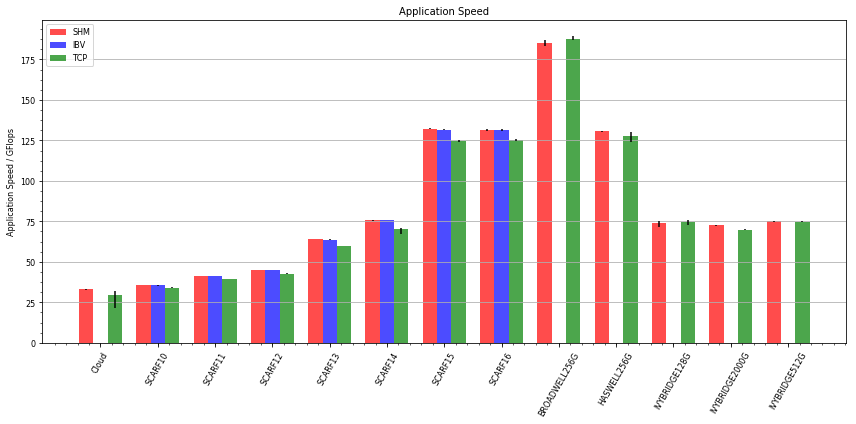

In [4]:
def plotGflops(BW_KEY="Gflops"):
    
    xValues = []
    clrs = {"SHM": "r", "TCP":"g", "IBV":"b"}
    yValues = {"SHM":[], "TCP":[], "IBV":[]}
    yTopError = {"SHM":[], "TCP":[], "IBV":[]}
    yBottomError = {"SHM":[], "TCP":[], "IBV":[]}
    
    def addBarData(listOfData, label):
        listOfData = [float(val) for val in listOfData]
        nonlocal yValues
        nonlocal yTopError
        nonlocal yBottomError
        avg = sum(listOfData) / len(listOfData)
        yValues[label].append(avg)
        yTopError[label].append(max(listOfData) - avg)
        yBottomError[label].append(avg - min(listOfData))
    
    
    # Add the cloud split into number of hosts
    addBarData([row[BW_KEY] for row in results["Cloud_HPL"] if row["Number of Hosts"] == "1"], "SHM")
    addBarData([row[BW_KEY] for row in results["Cloud_HPL"] if row["Number of Hosts"] == "2"], "TCP")
    addBarData([0], "IBV")

    xValues.append("Cloud")
    
   
    # Add the JASMIN and SCARF data split into host group and number of hosts
    for name in ("SCARF_HPL", "JASMIN_HPL"):
        for hostgroup in sorted(set(row["Host Groups"] for row in results[name])):
            xValues += [hostgroup]
            for prot in clrs.keys():
                
                thisData = [row[BW_KEY] for row in results[name] 
                            if hostgroup in row["Host Groups"] and prot == row["Protocols Seen"]]
                if len(thisData) == 0:  # if no data then there is a divide by zero so send this (mostly IBV)
                    addBarData([0], prot)
                else:
                    addBarData(thisData, prot)
    
    index = np.arange(len(xValues)) - 1
    
    
    bar_width=0.25
    plt.rcParams["figure.figsize"] = (12,6)
    ax = plt.gca()
    plt.minorticks_on()
    ax.yaxis.grid(True, which='major', linestyle='-')
    # ax.yaxis.grid(True, which='minor', linestyle='')
    
    for i, (label, yVals) in enumerate(yValues.items()):
        plt.bar(index + i * bar_width, yVals, bar_width, align='center', color=clrs[label], alpha=0.7, label=label)
        plt.errorbar(index + i * bar_width, yVals, yerr=[yBottomError[label], yTopError[label]], linestyle=" ", 
                     color="black", zorder=6)
    
    print(makeLatexTableContent(xV))
    
    plt.xticks(index + bar_width, xValues, rotation=60)
    plt.ylabel("Application Speed / GFlops")
    # plt.yscale("log")
    plt.title('Application Speed')
    
    plt.legend(loc=2, fontsize=8)
    plt.tight_layout()
    plt.savefig('applicationSpeed.png', format="png")
    plt.show()
    


plotGflops()